In [1]:
from transformers import Wav2Vec2Processor, Wav2Vec2Model, AutoProcessor
import librosa
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from transformers import AutoModel, Wav2Vec2FeatureExtractor

In [2]:
from torch import nn
class GenreClassificationModel(nn.Module):
    def __init__(self, encoder):
        super(GenreClassificationModel, self).__init__()
        self.encoder = encoder
        self.layer_1 = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512)
        )
        self.layer_2 = nn.Linear(512, 10)

    def forward(self, audio_input):
        outputs = self.encoder(**audio_input, output_hidden_states=True).last_hidden_state
        time_reduced_hidden = outputs.mean(-2)
        hidden = self.layer_1(time_reduced_hidden)
        output = self.layer_2(hidden)
        return output
    
class GenreClassificationModelCLAP(nn.Module):
    def __init__(self, encoder):
        super(GenreClassificationModelCLAP, self).__init__()
        self.encoder = encoder
        self.layer_1 = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512)
        )
        self.layer_2 = nn.Linear(512, 10)

    def forward(self, audio_input):
        outputs = self.encoder.get_audio_features(**audio_input)
        hidden = self.layer_1(outputs)
        output = self.layer_2(hidden)
        return output

In [3]:
# Load the pre-trained Wav2Vec model and processor
# model_name = "facebook/wav2vec2-base"
# processor = Wav2Vec2Processor.from_pretrained(model_name)
# model = Wav2Vec2Model.from_pretrained(model_name)
# loaded_model = GenreClassificationModel(encoder=model)
# loaded_model.load_state_dict(torch.load('wav2vec_unfrozen.pth'))
# model = loaded_model.encoder

# model = AutoModel.from_pretrained("m-a-p/MERT-v1-330M", trust_remote_code=True)
# processor = Wav2Vec2FeatureExtractor.from_pretrained("m-a-p/MERT-v1-330M", trust_remote_code=True)
# loaded_model = GenreClassificationModel(encoder=model)
# loaded_model.load_state_dict(torch.load('mert_unfrozen.pth'))
# model = loaded_model.encoder

processor = AutoProcessor.from_pretrained("laion/larger_clap_music")
model = AutoModel.from_pretrained("laion/larger_clap_music")
loaded_model = GenreClassificationModelCLAP(encoder=model)
loaded_model.load_state_dict(torch.load('clap_unfrozen.pth'))
model = loaded_model.encoder


/var/tmp/ipykernel_32888/2048684343.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('clap_unfrozen.pth'))


In [4]:
data_dir = "/home/thomasyim/.cache/kagglehub/datasets/andradaolteanu/"\
    + "gtzan-dataset-music-genre-classification/versions/1"

In [5]:

def extract_embeddings_wav2vec(audio_file):
    """Extract Wav2Vec embeddings for a given audio file."""
    audio, sample_rate = librosa.load(audio_file, sr=16000)  # Resample to 16kHz
    input_values = processor(audio[:48000], sampling_rate=sample_rate, return_tensors="pt").input_values

    # Get embeddings from the model
    with torch.no_grad():
        outputs = model(input_values)
        embeddings = outputs.last_hidden_state.squeeze(0).mean(dim=0)  # Mean pooling over time
    return embeddings.numpy()

def extract_embeddings_mert(audio_file):
    audio, sample_rate = librosa.load(audio_file, sr=24000)  # Resample to 16kHz
    input_values = processor(audio[:72000], sampling_rate=sample_rate, return_tensors="pt").input_values

    # Get embeddings from the model
    with torch.no_grad():
        outputs = model(input_values)
        embeddings = outputs.last_hidden_state.squeeze(0).mean(dim=0)  # Mean pooling over time
    return embeddings.numpy()

def extract_embeddings_clap(audio_file):
    audio, sample_rate = librosa.load(audio_file, sr=48000)  # Resample to 16kHz
    input_values = processor(audios=audio[:144000], sampling_rate=sample_rate, return_tensors="pt")

    # Get embeddings from the model
    with torch.no_grad():
        outputs = model.get_audio_features(**input_values)
    return outputs.numpy()




In [33]:
def plot_pca(embeddings, labels, model_type):
    """Perform PCA on embeddings and plot the results."""
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    for i, label in enumerate(set(labels)):
        idx = [j for j, l in enumerate(labels) if l == label]
        plt.scatter(
            reduced_embeddings[idx, 0],
            reduced_embeddings[idx, 1],
            label=label
        )
    plt.title(f"PCA of {model_type} Embeddings")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid()
    plt.savefig(f"{model_type}.png")
    plt.show()

In [7]:
import pandas as pd
df_train = pd.read_csv("classification_train.csv")
labels = list(df_train["genres"])

In [8]:
from tqdm import tqdm

all_embeddings= []
for audio_file, genre in tqdm(zip(list(df_train["filename"]), labels)):
    embeddings = extract_embeddings_clap(f"{data_dir}/Data/genres_original/{genre}/{audio_file}")
    all_embeddings.append(embeddings)

800it [05:44,  2.32it/s]


In [12]:
np.savetxt("clap_unfrozen_embeddings.txt", np.array(all_embeddings).reshape(800,512))

In [13]:
import numpy as np
mert_embeddings = np.loadtxt("mert_embeddings.txt")
mert_unfrozen_embeddings = np.loadtxt("mert_unfrozen_embeddings.txt")

wav2vec_embeddings = np.loadtxt("wav2vec_embeddings.txt")
wav2vec_unfrozen_embeddings = np.loadtxt("wav2vec_unfrozen_embeddings.txt")

clap_embeddings = np.loadtxt("clap_embeddings.txt")
clap_unfrozen_embeddings = np.loadtxt("clap_unfrozen_embeddings.txt")


In [14]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def average_pairwise_cosine_similarity(embeddings):
    """
    Calculate the average pairwise cosine similarity for a list of embeddings.

    Args:
        embeddings (list or np.ndarray): List or array of embeddings (each embedding is a vector).

    Returns:
        float: The average pairwise cosine similarity.
    """
    embeddings = np.array(embeddings)  # Ensure it's a numpy array
    n = len(embeddings)

    if n < 2:
        raise ValueError("At least two embeddings are required to calculate pairwise similarities.")
    
    # Compute cosine similarity for all pairs
    similarity_matrix = cosine_similarity(embeddings)
    
    # Extract upper triangular part without diagonal (to avoid self-similarities)
    upper_triangle_indices = np.triu_indices(n, k=1)
    pairwise_similarities = similarity_matrix[upper_triangle_indices]

    # Compute the average
    avg_similarity = np.mean(pairwise_similarities)
    return avg_similarity

result = average_pairwise_cosine_similarity(clap_embeddings)
print(f"Average pairwise cosine similarity of MERT (frozen): {average_pairwise_cosine_similarity(mert_embeddings)}")
print(f"Average pairwise cosine similarity of MERT (unfrozen): {average_pairwise_cosine_similarity(mert_unfrozen_embeddings)}")

print(f"Average pairwise cosine similarity of Wav2Vec (frozen): {average_pairwise_cosine_similarity(wav2vec_embeddings)}")
print(f"Average pairwise cosine similarity of Wav2Vec (unfrozen): {average_pairwise_cosine_similarity(wav2vec_unfrozen_embeddings)}")

print(f"Average pairwise cosine similarity of CLAP (frozen): {average_pairwise_cosine_similarity(clap_embeddings)}")
print(f"Average pairwise cosine similarity of CLAP (unfrozen): {average_pairwise_cosine_similarity(clap_unfrozen_embeddings)}")




Average pairwise cosine similarity of MERT (frozen): 0.8487323023271168
Average pairwise cosine similarity of MERT (unfrozen): 0.6994529708168913
Average pairwise cosine similarity of Wav2Vec (frozen): 0.7241171481773006
Average pairwise cosine similarity of Wav2Vec (unfrozen): 0.6843374116219985
Average pairwise cosine similarity of CLAP (frozen): 0.9710984800302673
Average pairwise cosine similarity of CLAP (unfrozen): 0.562270453594195


In [6]:
import pandas as pd
df_train = pd.read_csv("classification_train.csv")
labels = list(df_train["genres"])

In [8]:
print(mert_embeddings.shape)
print(wav2vec_embeddings.shape)
print(clap_embeddings.shape)

(800, 1024)
(800, 768)
(800, 512)


In [15]:
def filter_embeddings_by_labels(embeddings, labels, allowed_labels):
    """
    Filters embeddings and labels based on allowed labels.

    Args:
        embeddings (list or np.ndarray): Array or list of embeddings.
        labels (list): List of labels corresponding to each embedding.
        allowed_labels (list): List of labels to retain (e.g., ['classical', 'metal']).

    Returns:
        np.ndarray, list: Filtered embeddings and labels.
    """
    embeddings = np.array(embeddings)  # Ensure embeddings are a numpy array
    labels = np.array(labels)          # Ensure labels are a numpy array

    # Create a mask for labels that match the allowed labels
    mask = np.isin(labels, allowed_labels)

    # Apply the mask to embeddings and labels
    filtered_embeddings = embeddings[mask]
    filtered_labels = labels[mask]

    return filtered_embeddings, filtered_labels

In [17]:
to_filter = ["classical", "metal"]
mert_embeddings_filtered, labels_filtered = filter_embeddings_by_labels(mert_embeddings, labels, to_filter)
mert_unfrozen_embeddings_filtered, labels_filtered = filter_embeddings_by_labels(mert_unfrozen_embeddings, labels, to_filter)

wav2vec_embeddings_filtered, labels_filtered = filter_embeddings_by_labels(wav2vec_embeddings, labels, to_filter)
wav2vec_unfrozen_embeddings_filtered, labels_filtered = filter_embeddings_by_labels(wav2vec_unfrozen_embeddings, labels, to_filter)

clap_embeddings_filtered, labels_filtered = filter_embeddings_by_labels(clap_embeddings, labels, to_filter)
clap_unfrozen_embeddings_filtered, labels_filtered = filter_embeddings_by_labels(clap_unfrozen_embeddings, labels, to_filter)

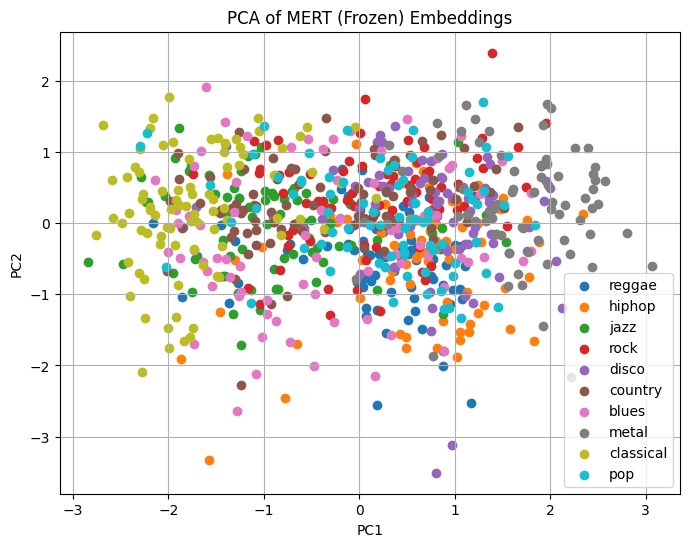

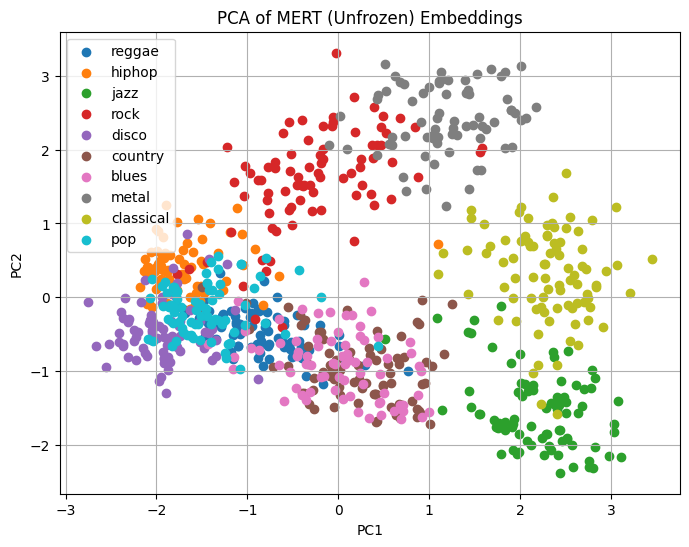

In [34]:
plot_pca(mert_embeddings, labels, "MERT (Frozen)")
plot_pca(mert_unfrozen_embeddings, labels, "MERT (Unfrozen)")

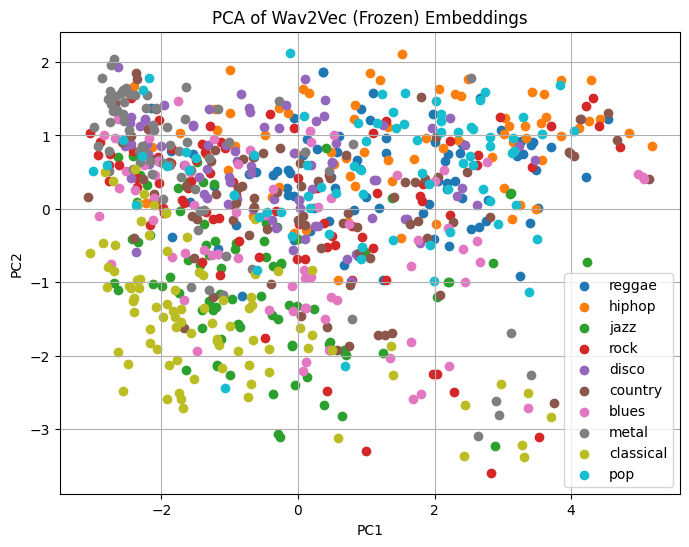

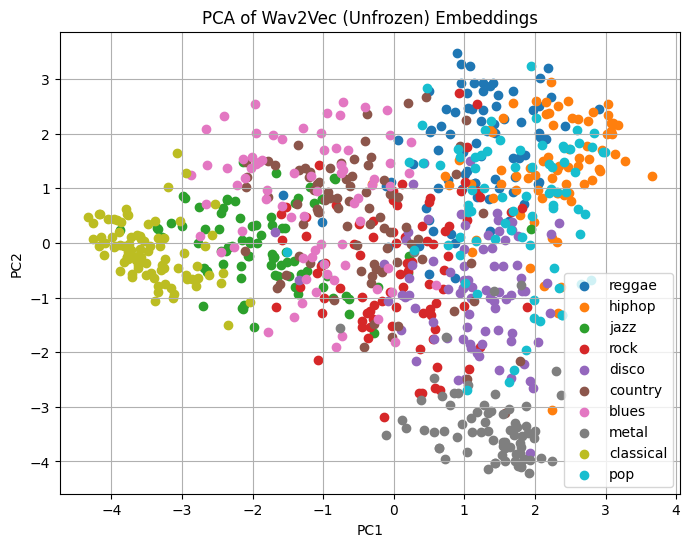

In [35]:
plot_pca(wav2vec_embeddings, labels, "Wav2Vec (Frozen)")
plot_pca(wav2vec_unfrozen_embeddings, labels, "Wav2Vec (Unfrozen)")

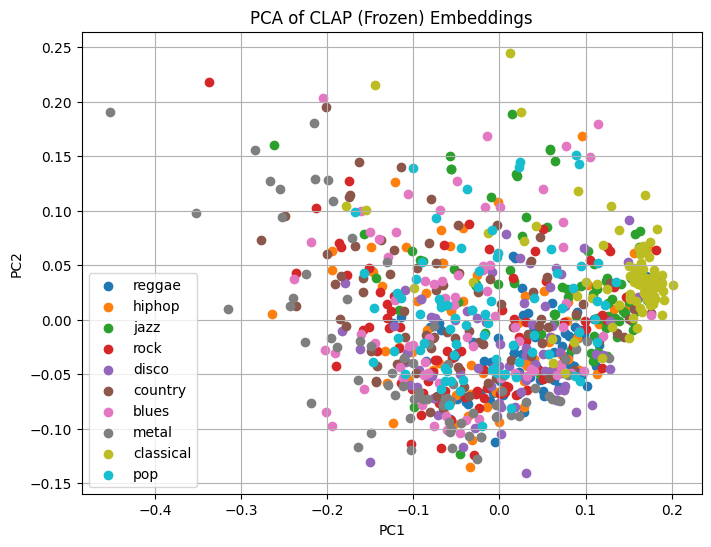

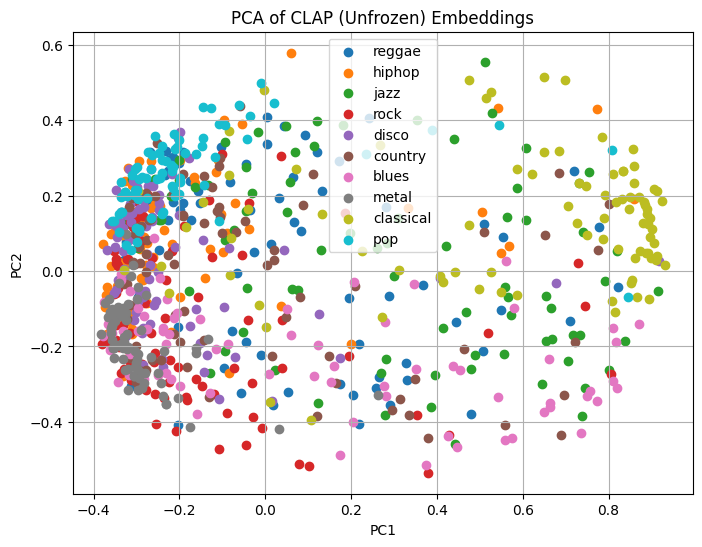

In [36]:
plot_pca(clap_embeddings, labels, "CLAP (Frozen)")
plot_pca(clap_unfrozen_embeddings, labels, "CLAP (Unfrozen)")

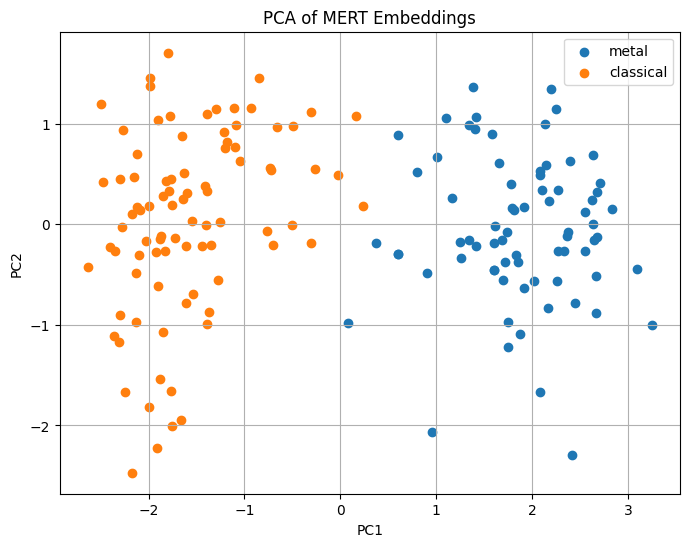

In [18]:
plot_pca(mert_embeddings_filtered, labels_filtered, "MERT")

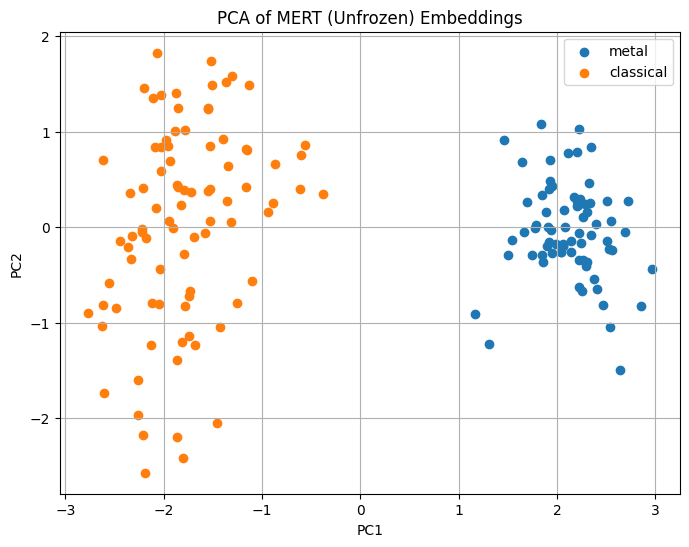

In [19]:
plot_pca(mert_unfrozen_embeddings_filtered, labels_filtered, "MERT (Unfrozen)")

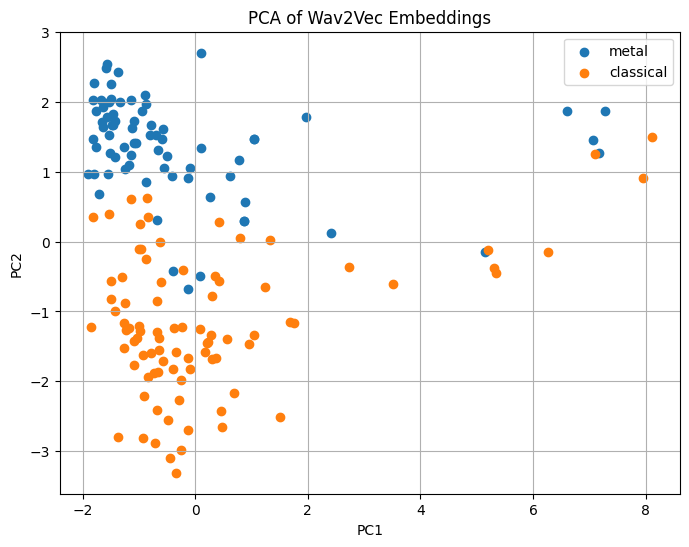

In [16]:
plot_pca(wav2vec_embeddings_filtered, labels_filtered, "Wav2Vec (Frozen)")

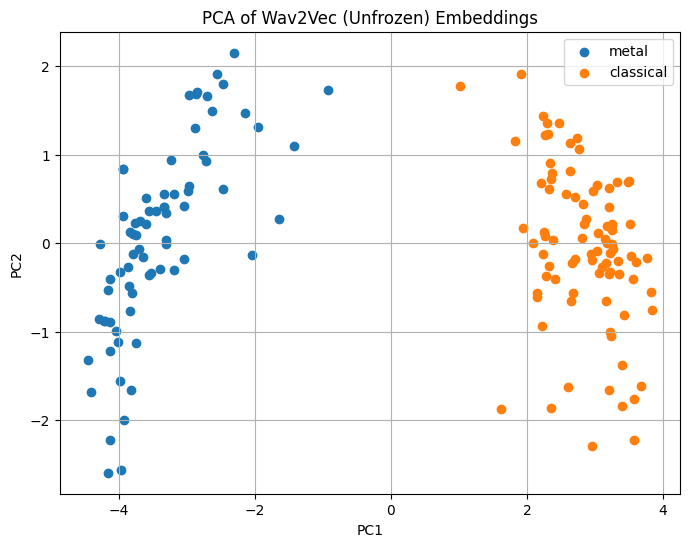

In [20]:
plot_pca(wav2vec_unfrozen_embeddings_filtered, labels_filtered, "Wav2Vec (Unfrozen)")

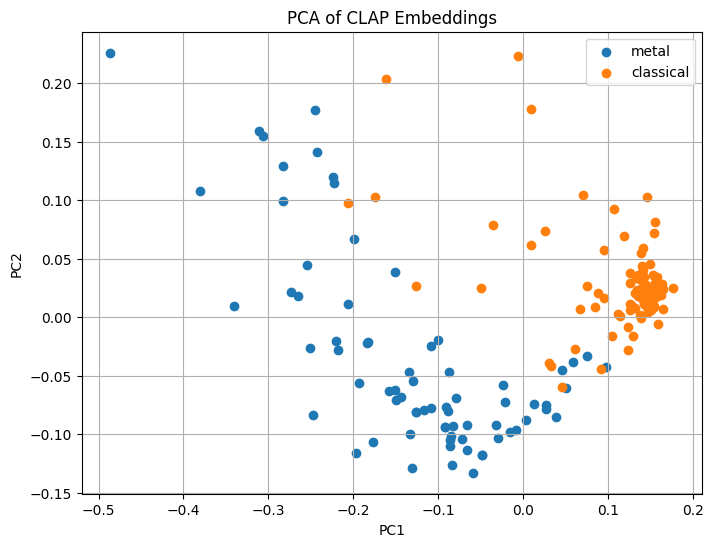

In [18]:
plot_pca(clap_embeddings_filtered, labels_filtered, "CLAP")

In [ ]:
plot_pca(clap_embeddings, labels_filtered, "CLAP")